# Language Detection

A language detection model is a model that can detect the language of a given text. This is a very useful model for many applications, such as:
- Language translation
- Language specific text processing
- Language specific text analysis
- Voice recognition
- Virtual assistants

There are many approaches to language detection. In this notebook, we will use a many approaches to detect the language of a given text. We will use the following approaches:

- Approach 1: Using a language detection library
- Approach 2: Using a character n-gram model
- Approach 3: [Using Mutual Information based Distance Measure.](https://www.engati.com/glossary/language-detection#:~:text=and%20Live%20Chat-,How%20language%20detection%20works%3F,strongest%20correlation%20to%20a%20corpus.)
- Approach 4: Using deep learning

## Approach 1: Language Detection library

In [11]:
import os

import iso639 
import langid
import fasttext
import langdetect
import fasttext.util

from iso639 import *
from langdetect import *
from sklearn.metrics import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import nbformat
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


model = SentenceTransformer('all-MiniLM-L6-v2')
from sentence_transformers import SentenceTransformer



os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
df = pd.read_csv('../data/Language.csv')

In [3]:
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


## Useful Functions

In [4]:
def iso2str(text : str) -> str:
    '''conversion from iso to string 
    Args:
        param text (str) : Input text 
    Returns:
        str
    ''' 
    try:
        return languages.get(alpha2=text).name
    except:
        return 'unknown'

In [6]:
def check_lang(text : str) -> str:
    '''check language of text using Langdetect
    Args:
        param text (str) : Input text
    Returns:
        str
    '''
    try:
        lang = detect(str(text))
    except lang_detect_exception.LangDetectException:
        lang = 'unknown'
    return lang   

In [ ]:
class LanguageIdentification:


    def __init__(self):
        pretrained_lang_model = "../models/lid.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text : str) -> str:
        ''' Language Identification using fasttext
        Args:
            param text (str) : Input text
        Return:
            str
        '''
        predictions = self.model.predict(text, k=1) 
        predictions = predictions[0][0].replace("__label__", "")
        return predictions

In [1]:
def multiclass_report(y_true, y_pred, labels):
    print(f'Accuracy: {np.mean(y_true == y_pred)}\nPercision: {np.mean(y_true == y_pred)}\nRecall: {np.mean(y_true == y_pred)}')
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
print("Using Langdetect")
df['langdetect'] = df['Text'].apply(check_lang)
df['langdetect'] = df['langdetect'].apply(iso2str)
multiclass_report(df['Language'], df['langdetect'], df['Language'].unique())


,Text,Language,langdetect
0,"Nature, in the broadest sense, is the natural...",English,English
1,"""Nature"" can refer to the phenomena of the phy...",English,English
2,"The study of nature is a large, if not the onl...",English,English
3,"Although humans are part of nature, human acti...",English,English
4,[1] The word nature is borrowed from the Old F...,English,English


In [9]:
print("Using Langid")
df['langid'] = df['Text'].apply(langid.classify)
df['langid'] = df['langid'].apply(lambda x: x[0])
df['langid'] = df['langid'].apply(iso2str)
multiclass_report(df['Language'], df['langid'], df['Language'].unique())

,Text,Language,langdetect,langid
0,"Nature, in the broadest sense, is the natural...",English,English,English
1,"""Nature"" can refer to the phenomena of the phy...",English,English,English
2,"The study of nature is a large, if not the onl...",English,English,English
3,"Although humans are part of nature, human acti...",English,English,English
4,[1] The word nature is borrowed from the Old F...,English,English,English


In [11]:
model = LanguageIdentification()

print("Using Fasttext")
df['Text'] = df['Text'].apply(lambda x: x.replace("\n", " "))
df['fasttext'] = df['Text'].apply(model.predict_lang)
df['fasttext'] = df['fasttext'].apply(iso2str)
multiclass_report(df['Language'], df['fasttext'], df['Language'].unique())

,Text,Language,langdetect,langid,fasttext
0,"Nature, in the broadest sense, is the natural...",English,English,English,English
1,"""Nature"" can refer to the phenomena of the phy...",English,English,English,English
2,"The study of nature is a large, if not the onl...",English,English,English,English
3,"Although humans are part of nature, human acti...",English,English,English,English
4,[1] The word nature is borrowed from the Old F...,English,English,English,English


In [14]:
print("Using Ngram")

def extract_ngrams(text:str, n:int)-> list:
    '''
    Given a text and an integer n, returns a list of all n-grams in the text.
    
    Args:
        text: The input text as a string.
        n: The length of the n-grams as an integer.
        
    Returns:
        A list of all n-grams in the text.
    '''
    ngrams = []
    for i in range(len(text)-n+1):
        ngrams.append(text[i:i+n])
    return ngrams


# Create a frequency table for each language
n = 3  # The length of the n-grams
freq_tables = {}
for lang in df['Language'].unique():
    texts = df.loc[df['Language'] == lang, 'Text']
    freq_table = {}
    for text in texts:
        # Extract all n-grams from the text
        ngrams = extract_ngrams(text, n)
        for ngram in ngrams:
            # Increment the count for the n-gram in the frequency table
            freq_table[ngram] = freq_table.get(ngram, 0) + 1
        
        # Normalize the frequency table by the total number of n-grams in the text
        total_ngrams = sum(freq_table.values())
        for ngram in freq_table:
            freq_table[ngram] /= total_ngrams
        
    # Add the frequency table for the language to the dictionary
    freq_tables[lang] = freq_table


# Make predictions for each text in the dataset
predictions = []
for i, text in enumerate(df['Text']):
    # Extract all n-grams from the text
    ngrams = extract_ngrams(text, n)
    
    # Compute the probability of the text belonging to each language
    probs = {}
    for lang in freq_tables:
        prob = 1
        for ngram in ngrams:
            # Multiply the probability of each n-gram in the text belonging to the language
            prob *= freq_tables[lang].get(ngram, 0)
        probs[lang] = prob
        
    # Choose the language with the highest probability as the prediction for the text
    lang_pred = max(probs, key=probs.get)
    predictions.append(lang_pred)

# Add the predictions to the dataframe
df['Prediction'] = predictions
multiclass_report(df['Language'], df['Prediction'], df['Language'].unique())

In [16]:
df1 = pd.read_csv('../data/Language.csv')

df1['Text'] = df1['Text'].apply(lambda x: x.replace("\n", " "))
df1['Text'] = df1['Text'].apply(lambda x: x.replace("\t", " "))
df1['Text'] = df1['Text'].apply(lambda x: x.replace("  ", " "))

def embedding(text):
    return model.encode(text)

df1['embedding'] = df1['Text'].apply(embedding)

2023-04-30 19:30:46.666140: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-30 19:30:46.711984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 19:30:46.920117: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 19:30:46.920783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 19:30:48.135525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [17]:
df1.head()

,Text,Language,embedding
0,"Nature, in the broadest sense, is the natural...",English,"[0.0638107, -0.02032167, 0.022865308, 0.080334..."
1,"""Nature"" can refer to the phenomena of the phy...",English,"[0.04028565, 0.01301233, 0.010959733, 0.138003..."
2,"The study of nature is a large, if not the onl...",English,"[0.07350297, 0.06153041, 0.08317, 0.07226973, ..."
3,"Although humans are part of nature, human acti...",English,"[0.04971937, -0.046503335, 0.06687324, 0.04738..."
4,[1] The word nature is borrowed from the Old F...,English,"[0.026049452, 0.031227026, 0.010860803, 0.1173..."


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


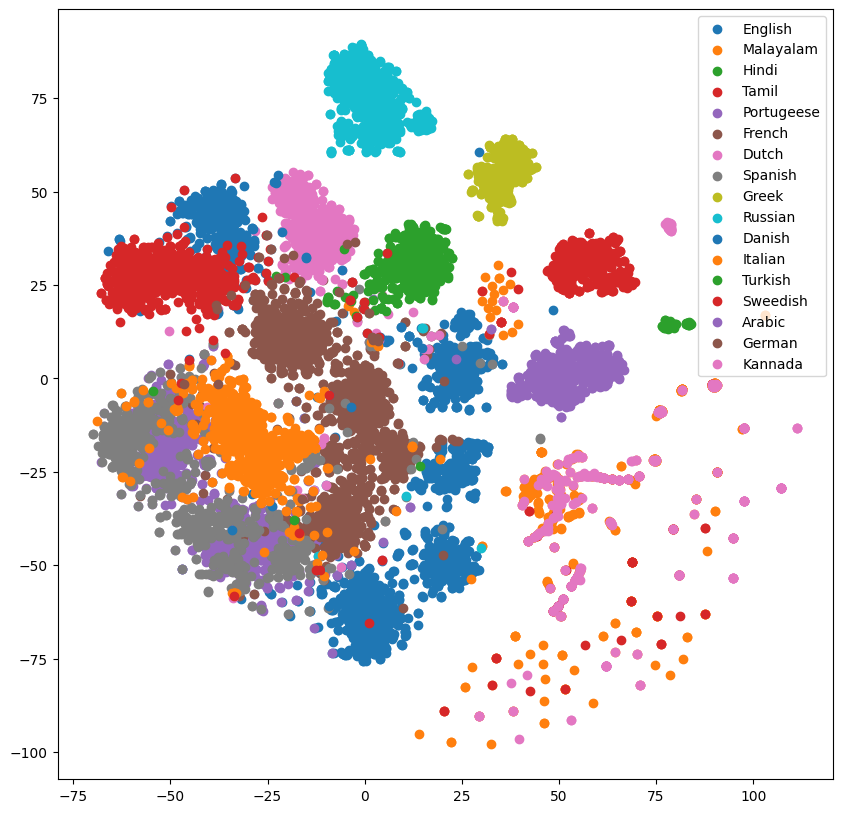

In [18]:
X = np.array(df1['embedding'].tolist())
y = df1['Language'].values

X_embedded = TSNE(n_components=2).fit_transform(X)

plt.figure(figsize=(10, 10))

for i, lang in enumerate(df1['Language'].unique()):
    plt.scatter(X_embedded[y == lang, 0], X_embedded[y == lang, 1], label=lang)

plt.legend()
plt.show()

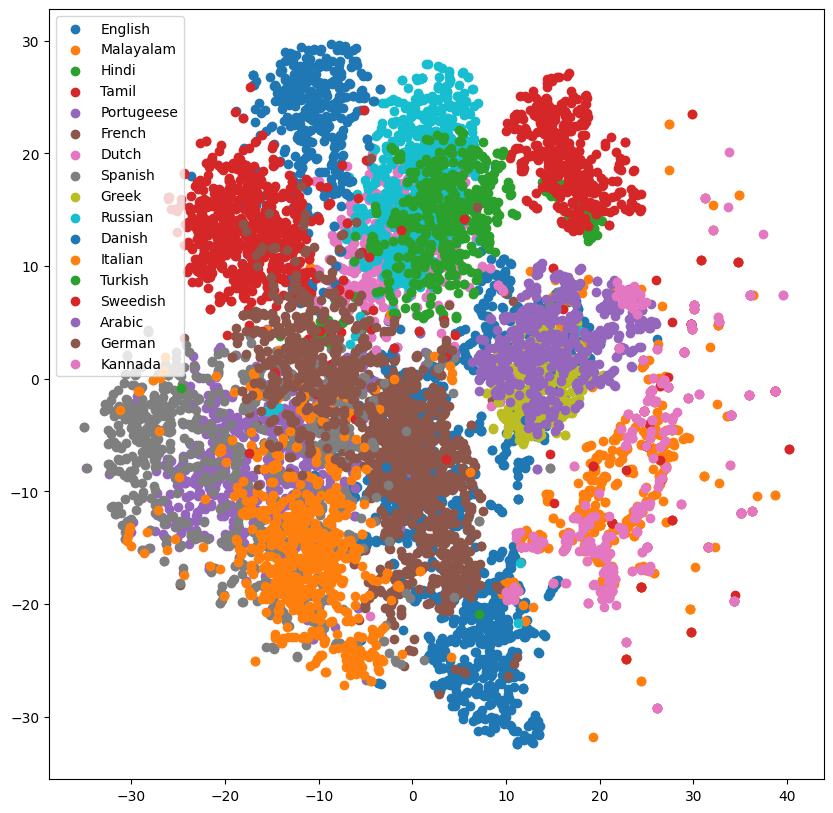

In [19]:
X = np.array(df1['embedding'].tolist())
y = df1['Language'].values

X_embedded = TSNE(n_components=3).fit_transform(X)

plt.figure(figsize=(10, 10))

for i, lang in enumerate(df1['Language'].unique()):
    plt.scatter(X_embedded[y == lang, 0], X_embedded[y == lang, 1], label=lang)

plt.legend()
plt.show()

In [20]:
X = np.array(df1['embedding'].tolist())
y = df1['Language'].values

X_embedded = TSNE(n_components=2).fit_transform(X)
fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=y)
fig.show()

In [21]:
import seaborn as sns
from sklearn.manifold import TSNE
import plotly.express as px
import nbformat

X = np.array(df1['embedding'].tolist())
y = df1['Language'].values

X_embedded = TSNE(n_components=2).fit_transform(X)

fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=y)

fig.show()

,Text,Language,langdetect,langid,fasttext,Prediction
0,"Nature, in the broadest sense, is the natural...",English,English,English,English,English
1,"""Nature"" can refer to the phenomena of the phy...",English,English,English,English,English
2,"The study of nature is a large, if not the onl...",English,English,English,English,English
3,"Although humans are part of nature, human acti...",English,English,English,English,English
4,[1] The word nature is borrowed from the Old F...,English,English,English,English,English


In [25]:
X = np.array(df1['embedding'].tolist())
y = df1['Language'].values

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model = Sequential()
model.add(Input(shape=(384,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()

# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
# mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

model.save('model.h5')

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                24640     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 17)                1105      
                                                                 
Total params: 25,745
Trainable params: 25,745
Non-trainable params: 0
_________________________________________________________________


2023-04-30 19:39:28.284641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-30 19:39:28.285890: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/25
259/259 [==============================] - 2s 3ms/step - loss: 1.5808 - accuracy: 0.6974 - val_loss: 0.6326 - val_accuracy: 0.8743
Epoch 2/25
259/259 [==============================] - 1s 3ms/step - loss: 0.5001 - accuracy: 0.8728 - val_loss: 0.3514 - val_accuracy: 0.9110
Epoch 3/25
259/259 [==============================] - 1s 3ms/step - loss: 0.3435 - accuracy: 0.8973 - val_loss: 0.2788 - val_accuracy: 0.9192
Epoch 4/25
259/259 [==============================] - 1s 2ms/step - loss: 0.2807 - accuracy: 0.9110 - val_loss: 0.2458 - val_accuracy: 0.9197
Epoch 5/25
259/259 [==============================] - 1s 3ms/step - loss: 0.2493 - accuracy: 0.9153 - val_loss: 0.2314 - val_accuracy: 0.9178
Epoch 6/25
259/259 [==============================] - 1s 2ms/step - loss: 0.2228 - accuracy: 0.9220 - val_loss: 0.2209 - val_accuracy: 0.9188
Epoch 7/25
259/259 [==============================] - 1s 2ms/step - loss: 0.2083 - accuracy: 0.9243 - val_loss: 0.2141 - val_accuracy: 0.9192
Epoch 

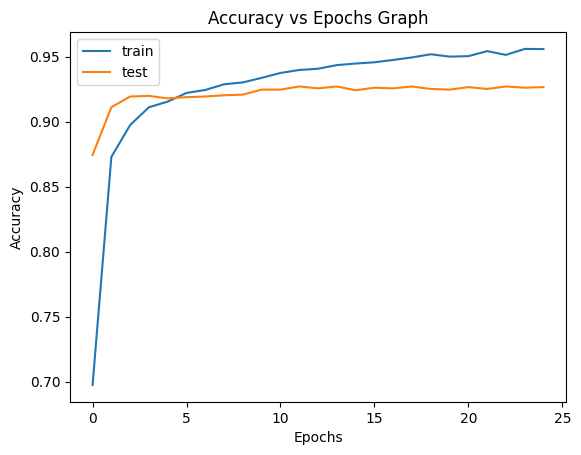

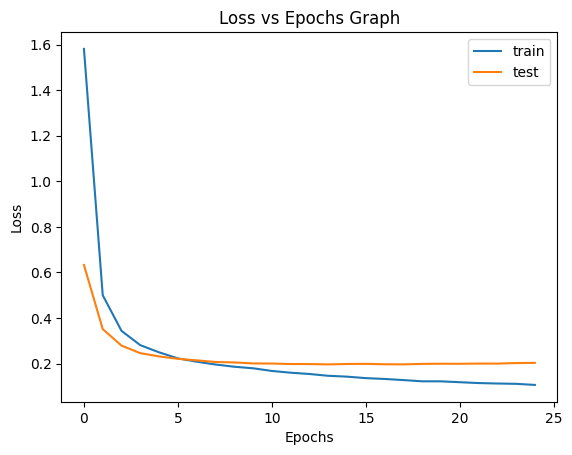

In [26]:

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs Graph')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs Graph')
plt.legend()
plt.show()


Using Sentence Transformer
Accuracy: 0.9264990328820116
Precison: 0.9259766902247373
Recall: 0.908992666019497
F1: 0.908432656862099


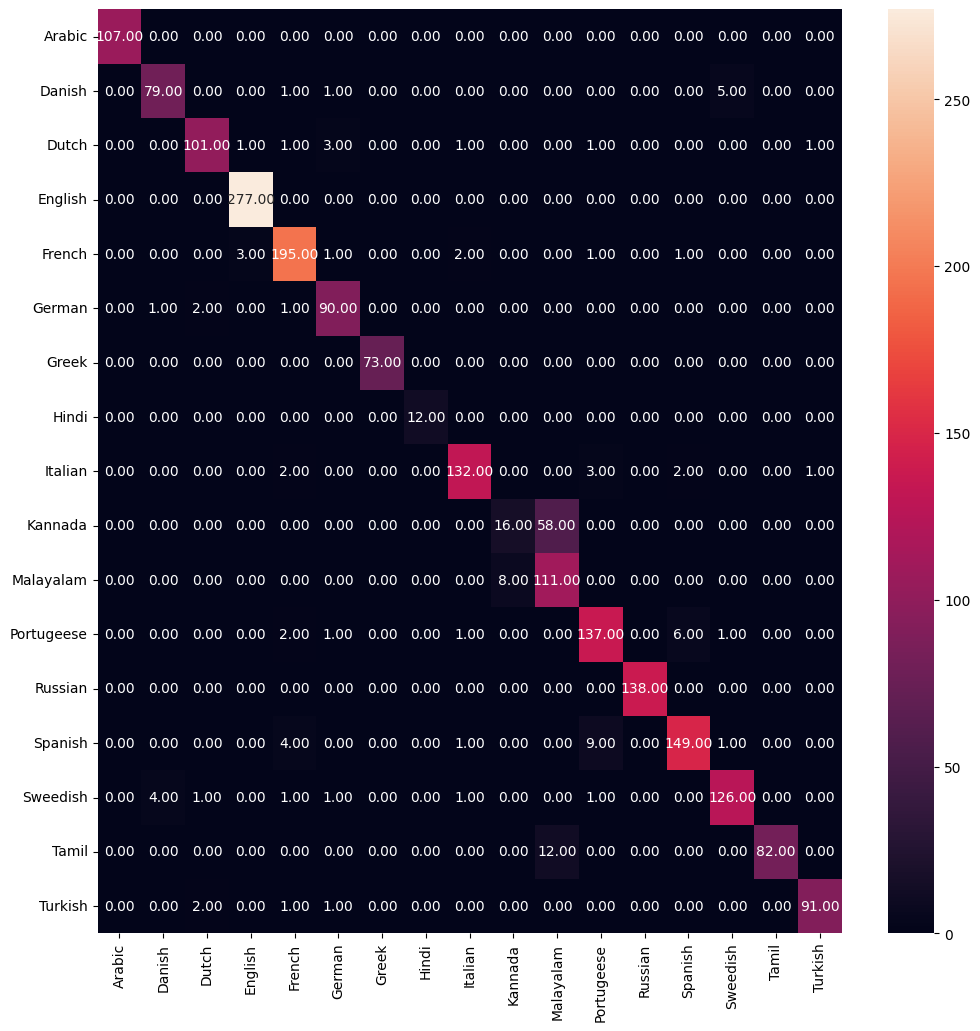

In [27]:
print("Using Sentence Transformer")
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Accuracy: {accuracy_score(y_test, y_pred)}\nPrecison: {precision_score(y_test, y_pred, average="macro")}\nRecall: {recall_score(y_test, y_pred, average="macro")}\nF1: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()


Model 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               49280     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 17)                1105      
                                                                 
Total params: 58,641
Trainable params: 58,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
259/259 [======================

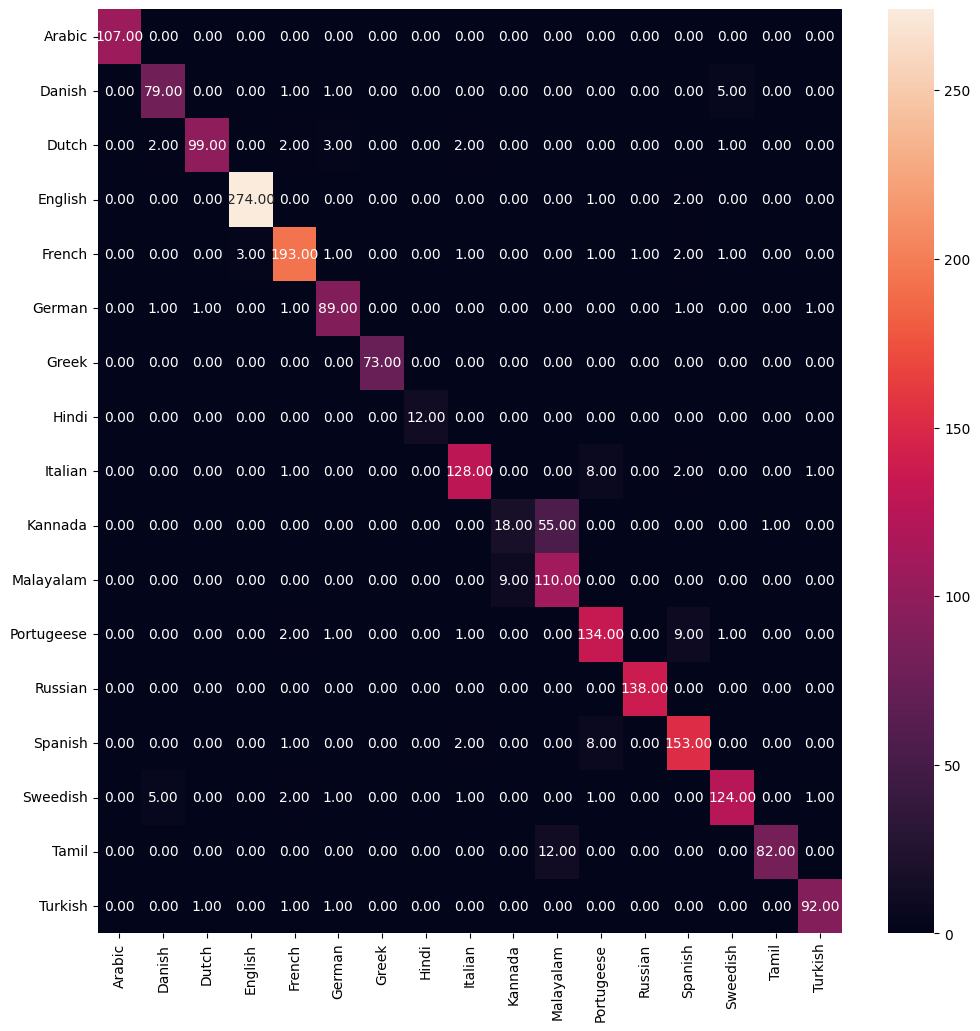

In [28]:
print("Model 2")

model = Sequential()
model.add(Input(shape=(384,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

model.save('model2.h5')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}\nprecision_score: {precision_score(y_test, y_pred, average="macro")}\nrecall_score: {recall_score(y_test, y_pred, average="macro")}\nf1_score: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()


Model 3
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               49280     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 17)       

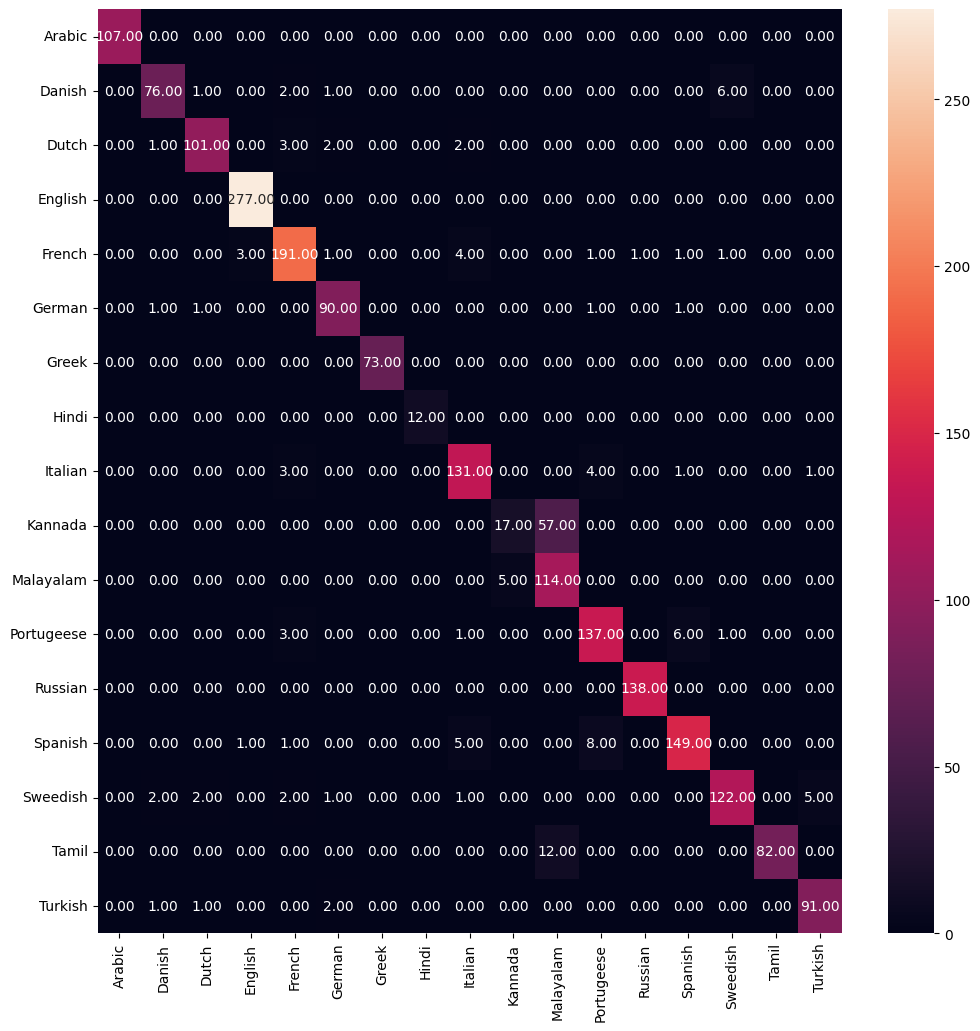

In [29]:
print("Model 3")

model = Sequential()
model.add(Input(shape=(384,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

model.save('model3.h5')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}\nprecision_score: {precision_score(y_test, y_pred, average="macro")}\nrecall_score: {recall_score(y_test, y_pred, average="macro")}\nf1_score: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()


Model 4
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 384, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 382, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 191, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 189, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 94, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 6016)     

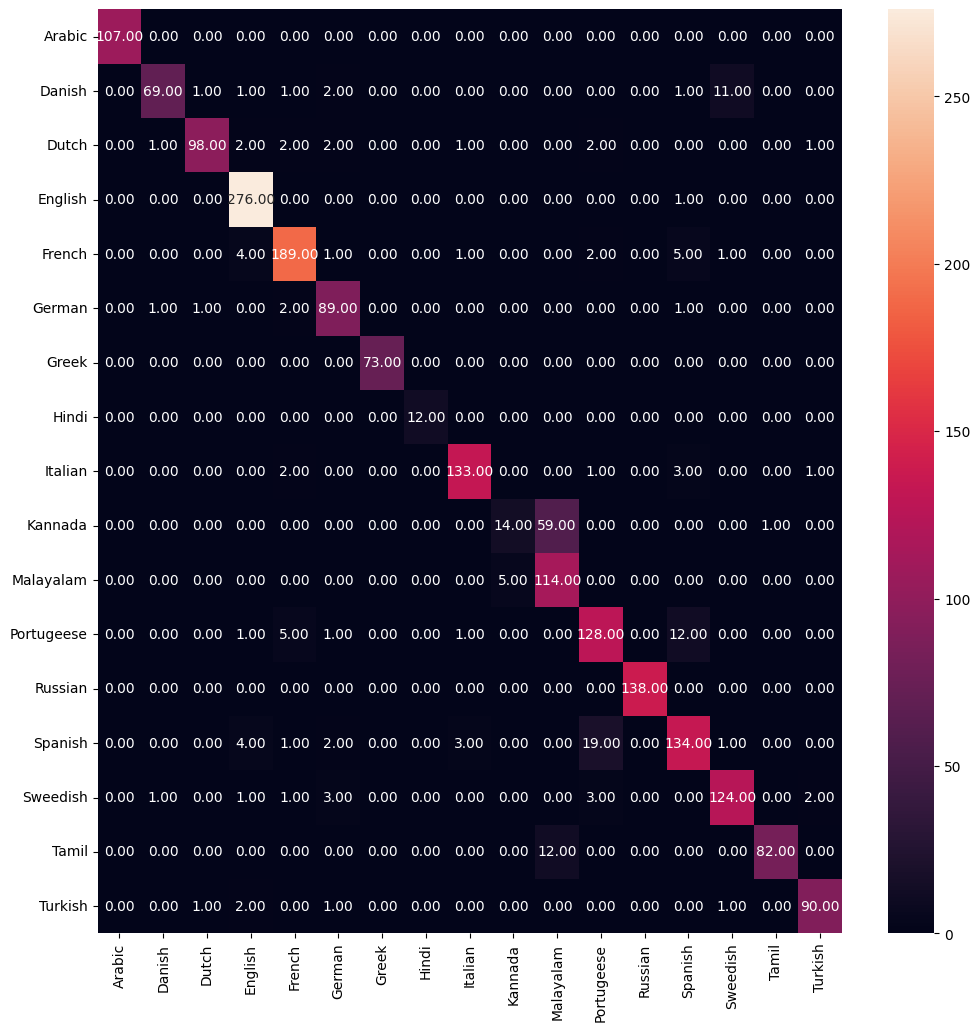

In [30]:

print("Model 4")

model = Sequential()
model.add(Input(shape=(384,)))
model.add(Reshape((384, 1)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

model.save('model4.h5')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}\nprecision_score: {precision_score(y_test, y_pred, average="macro")}\nrecall_score: {recall_score(y_test, y_pred, average="macro")}\nf1_score: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

Using LSTM


2023-04-30 19:43:31.824246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 19:43:31.826480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 19:43:31.827976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 384, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 384, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 17)                1105      
                                                                 
Total params: 51,025
Trainable params: 51,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-04-30 19:43:32.080499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 19:43:32.082627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 19:43:32.084256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

259/259 [==============================] - ETA: 0s - loss: 2.7375 - accuracy: 0.1330

2023-04-30 19:44:56.602638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 19:44:56.604596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 19:44:56.606239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

259/259 [==============================] - 91s 335ms/step - loss: 2.7375 - accuracy: 0.1330 - val_loss: 2.7241 - val_accuracy: 0.1339
Epoch 2/50
259/259 [==============================] - 87s 334ms/step - loss: 2.4421 - accuracy: 0.2033 - val_loss: 2.2008 - val_accuracy: 0.2587
Epoch 3/50
259/259 [==============================] - 82s 315ms/step - loss: 2.1057 - accuracy: 0.2959 - val_loss: 1.9313 - val_accuracy: 0.3462
Epoch 4/50
259/259 [==============================] - 84s 325ms/step - loss: 1.9492 - accuracy: 0.3506 - val_loss: 1.8218 - val_accuracy: 0.4038
Epoch 5/50
259/259 [==============================] - 82s 317ms/step - loss: 2.0686 - accuracy: 0.3091 - val_loss: 1.9507 - val_accuracy: 0.3554
Epoch 6/50
259/259 [==============================] - 77s 296ms/step - loss: 1.8195 - accuracy: 0.3927 - val_loss: 1.9008 - val_accuracy: 0.3835
Epoch 7/50
259/259 [==============================] - 74s 288ms/step - loss: 1.6482 - accuracy: 0.4496 - val_loss: 1.5700 - val_accuracy: 0.4

2023-04-30 20:41:11.544016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 20:41:11.545646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 20:41:11.546764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 6s 80ms/step
accuracy_score: 0.7132495164410058
precision_score: 0.7230614006942391
recall_score: 0.7073482821544992
f1_score: 0.7023238301425925


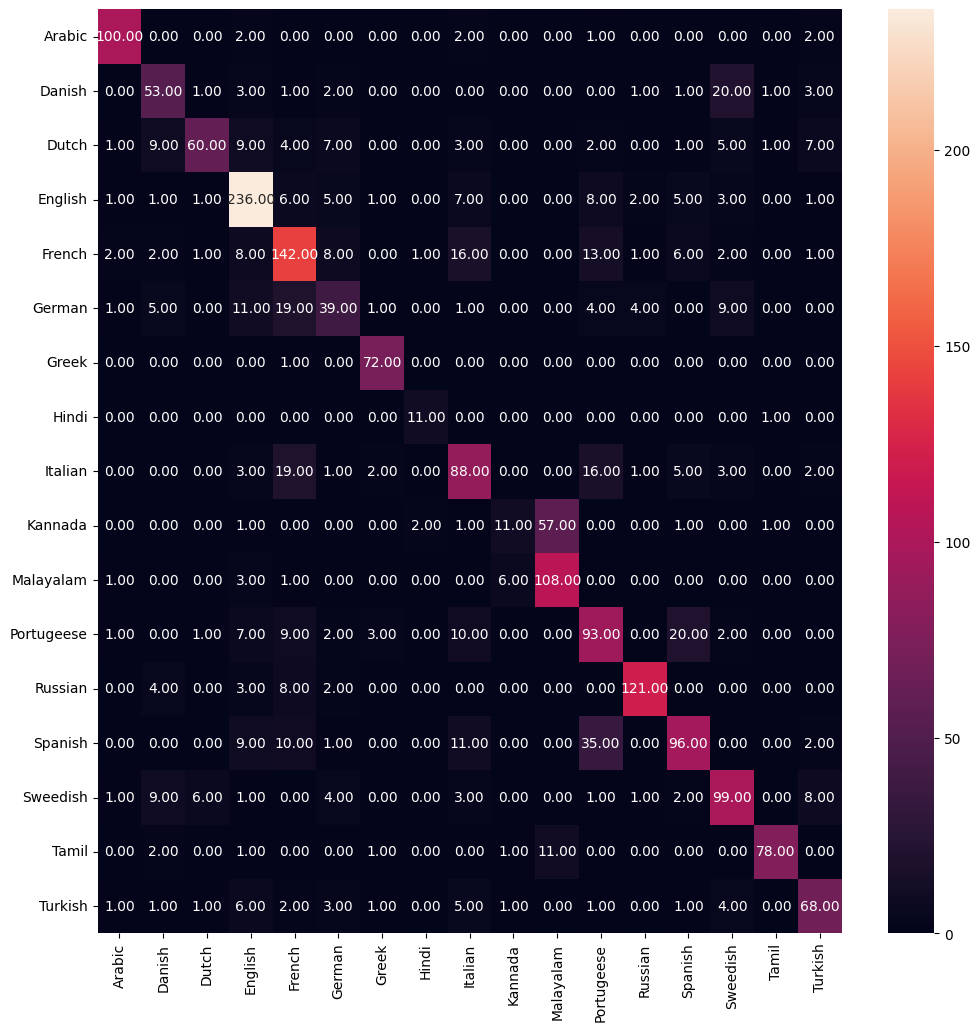

In [31]:
print('Using LSTM')


model = Sequential()
model.add(Input(shape=(384,)))
model.add(Reshape((384, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

model.save('model5.h5')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}\nprecision_score: {precision_score(y_test, y_pred, average="macro")}\nrecall_score: {recall_score(y_test, y_pred, average="macro")}\nf1_score: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

In [2]:

model = fasttext.load_model('../models/lid.bin')

def get_embedding(text):
    return model.get_sentence_vector(text)


In [3]:
df1 = pd.read_csv('../data/Language.csv')

df1['Text'] = df1['Text'].apply(lambda x: x.replace("\n", " "))
df1['Text'] = df1['Text'].apply(lambda x: x.replace("\t", " "))
df1['Text'] = df1['Text'].apply(lambda x: x.replace("  ", " "))


df1['Embedding'] = df1['Text'].apply(get_embedding)

In [4]:
X = np.array(df1['Embedding'].to_list())
y = np.array(df1['Language'].to_list())

le = LabelEncoder()

y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [5]:
model = Sequential()
model.add(Input(shape=(16,)))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

model.save('model18.h5')

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}\nprecision_score: {precision_score(y_test, y_pred, average="macro")}\nrecall_score: {recall_score(y_test, y_pred, average="macro")}\nf1_score: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                289       
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


2023-05-01 01:12:39.087815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 01:12:39.088398: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/25
259/259 [==============================] - 1s 2ms/step - loss: 2.3425 - accuracy: 0.5459 - val_loss: 1.9530 - val_accuracy: 0.8056
Epoch 2/25
259/259 [==============================] - 0s 1ms/step - loss: 1.6694 - accuracy: 0.8978 - val_loss: 1.4026 - val_accuracy: 0.9463
Epoch 3/25
259/259 [==============================] - 0s 1ms/step - loss: 1.2125 - accuracy: 0.9683 - val_loss: 1.0289 - val_accuracy: 0.9821
Epoch 4/25
259/259 [==============================] - 0s 1ms/step - loss: 0.9017 - accuracy: 0.9816 - val_loss: 0.7737 - val_accuracy: 0.9831
Epoch 5/25
259/259 [==============================] - 0s 1ms/step - loss: 0.6882 - accuracy: 0.9879 - val_loss: 0.5971 - val_accuracy: 0.9894
Epoch 6/25
259/259 [==============================] - 0s 1ms/step - loss: 0.5392 - accuracy: 0.9897 - val_loss: 0.4725 - val_accuracy: 0.9894
Epoch 7/25
259/259 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.9902 - val_loss: 0.3826 - val_accuracy: 0.9894
Epoch 

NameError: name 'y_pred' is not defined

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 16, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 14, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 64)             12352     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 128)              

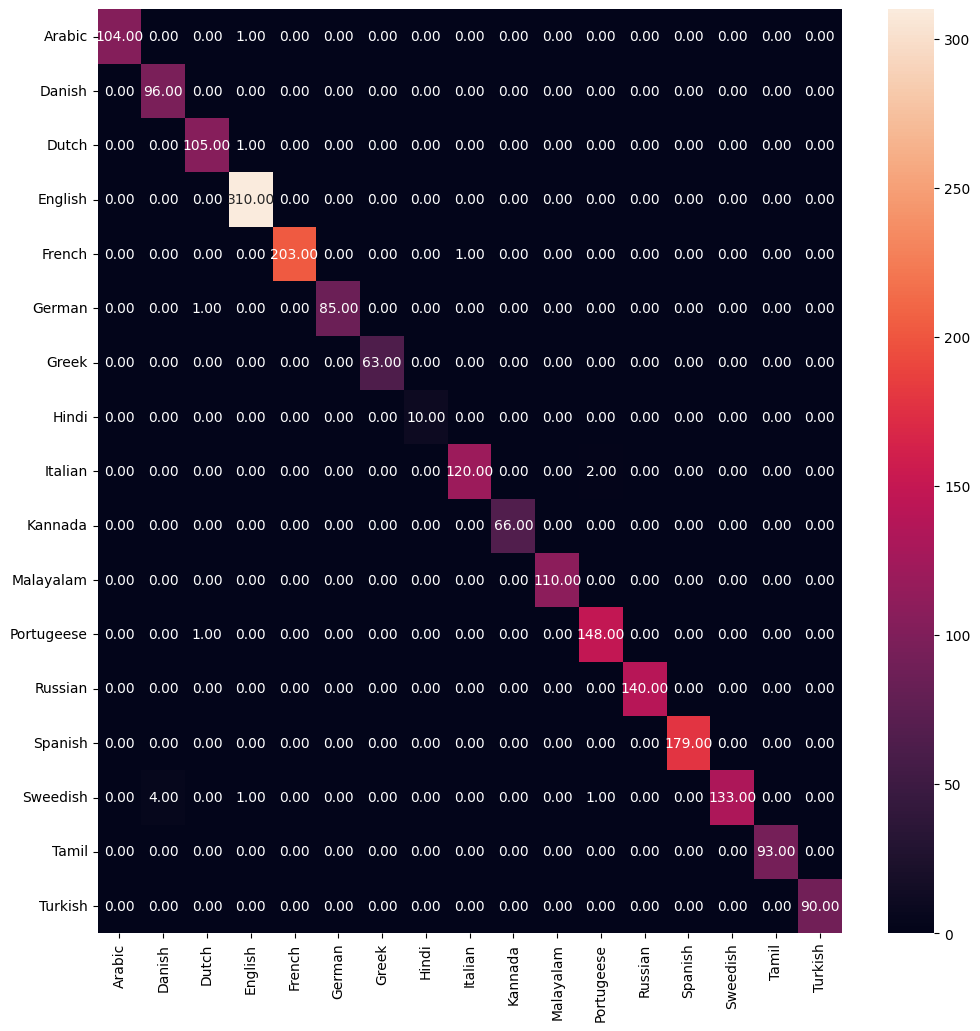

In [43]:
model = Sequential()

model.add(Input(shape=(16,)))
model.add(Reshape((16, 1)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

model.save('model6.h5')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}\nprecision_score: {precision_score(y_test, y_pred, average="macro")}\nrecall_score: {recall_score(y_test, y_pred, average="macro")}\nf1_score: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                1088      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 17)                1105      
                                                                 
Total params: 2,193
Trainable params: 2,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
259/259 [==============================] - 1s 2ms/step - loss: 1.5404 - accuracy: 0.8097 - val_loss: 0.4541 - val_accuracy: 0.9865
Epoch 2/25
259/259 [==============================] - 0s 2ms/step - loss: 0.2653 - accuracy: 0.9802 - val_loss: 0.1050 - val_accuracy: 0.9952
Epoch 3/25
259/259 [============

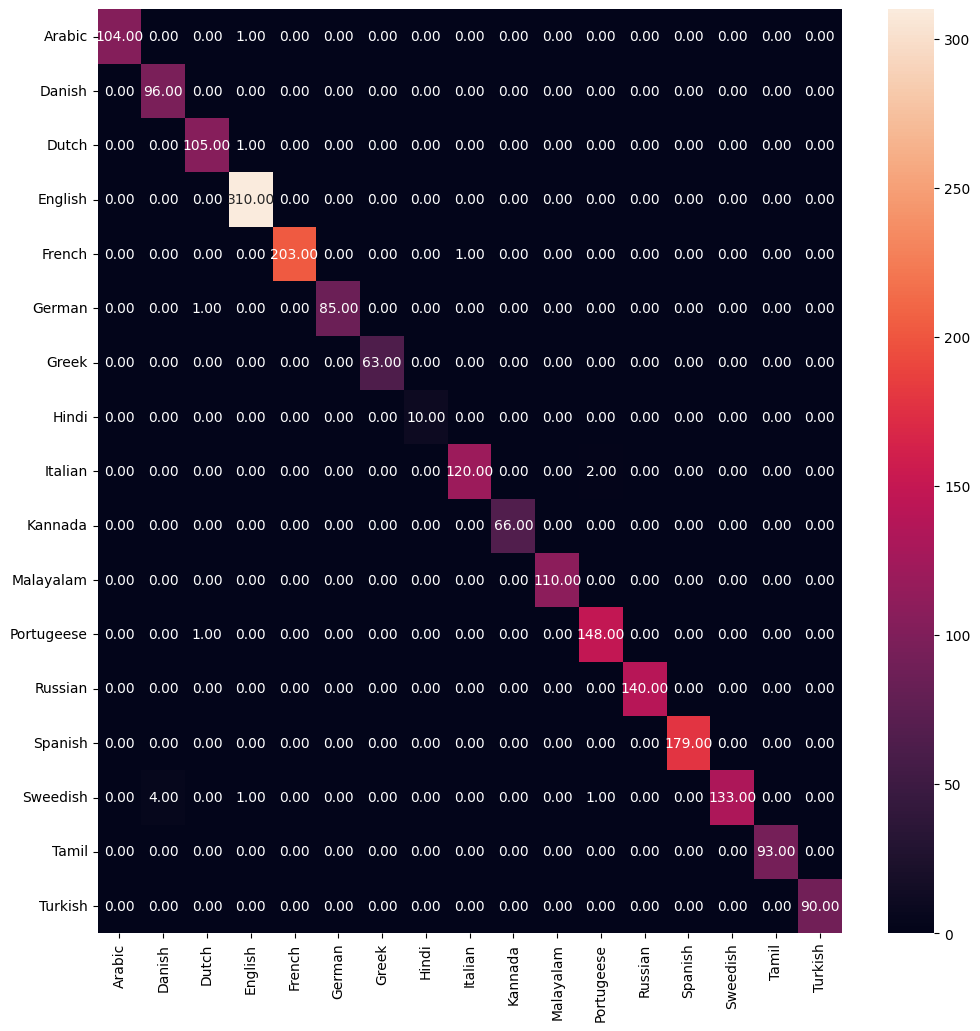

In [44]:
model = Sequential()
model.add(Input(shape=(16,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

model.save('model8.h5')

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}\nprecision_score: {precision_score(y_test, y_pred, average="macro")}\nrecall_score: {recall_score(y_test, y_pred, average="macro")}\nf1_score: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               2176      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 17)                1105      
                                                                 
Total params: 11,537
Trainable params: 11,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
259/259 [=============================

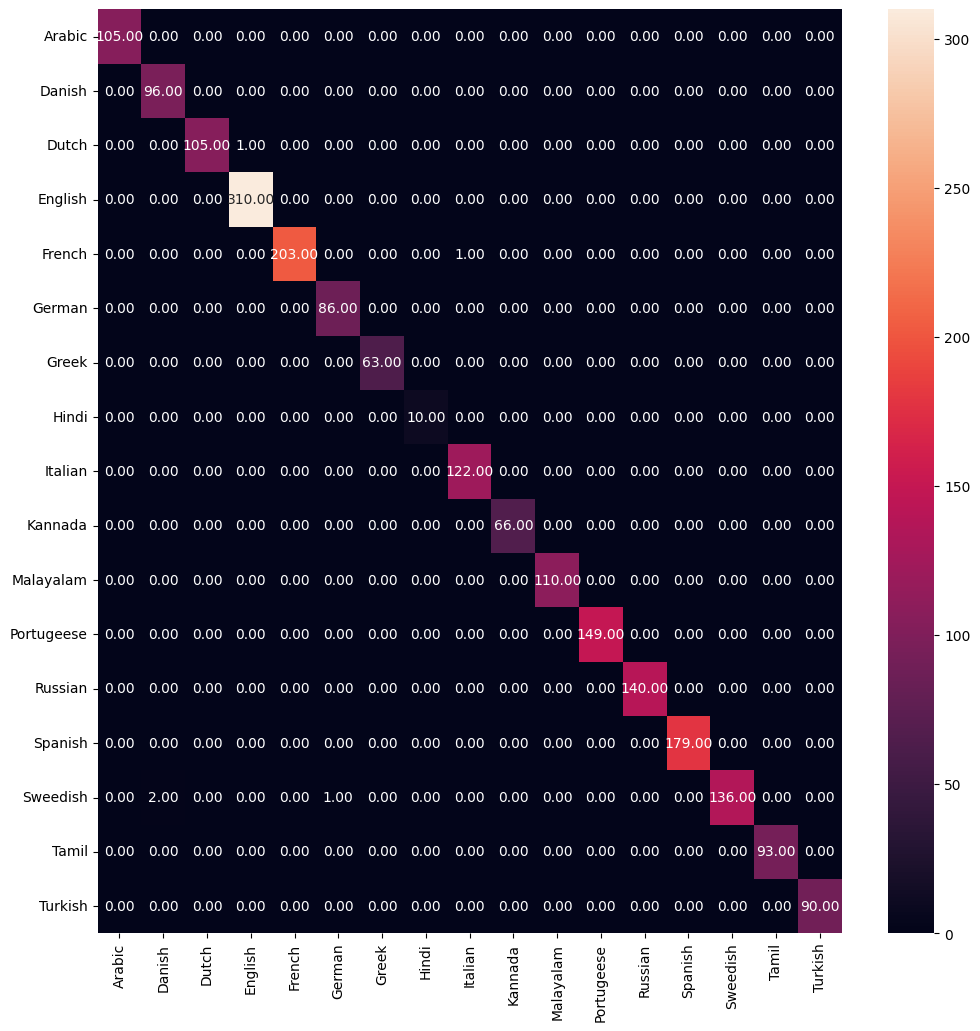

In [47]:
model = Sequential()
model.add(Input(shape=(16,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

model.save('model9.h5')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}\nprecision_score: {precision_score(y_test, y_pred, average="macro")}\nrecall_score: {recall_score(y_test, y_pred, average="macro")}\nf1_score: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 16, 1)             0         
                                                                 
 lstm_2 (LSTM)               (None, 16, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_22 (Dense)            (None, 17)                1105      
                                                                 
Total params: 51,025
Trainable params: 51,025
Non-trainable params: 0
_________________________________________________________________


2023-04-30 20:46:09.441543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 20:46:09.443664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 20:46:09.444729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-04-30 20:46:09.846418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 20:46:09.848283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 20:46:09.849730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

256/259 [============================>.] - ETA: 0s - loss: 1.2750 - accuracy: 0.6096

2023-04-30 20:46:14.716553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 20:46:14.718082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 20:46:14.719254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

259/259 [==============================] - 6s 12ms/step - loss: 1.2698 - accuracy: 0.6111 - val_loss: 0.5324 - val_accuracy: 0.8472
Epoch 2/50
259/259 [==============================] - 4s 16ms/step - loss: 0.4627 - accuracy: 0.8643 - val_loss: 0.3219 - val_accuracy: 0.9125
Epoch 3/50
259/259 [==============================] - 4s 15ms/step - loss: 0.3136 - accuracy: 0.9069 - val_loss: 0.2303 - val_accuracy: 0.9415
Epoch 4/50
259/259 [==============================] - 4s 15ms/step - loss: 0.2489 - accuracy: 0.9274 - val_loss: 0.1857 - val_accuracy: 0.9483
Epoch 5/50
259/259 [==============================] - 4s 15ms/step - loss: 0.1927 - accuracy: 0.9426 - val_loss: 0.2079 - val_accuracy: 0.9333
Epoch 6/50
259/259 [==============================] - 4s 15ms/step - loss: 0.1764 - accuracy: 0.9490 - val_loss: 0.1506 - val_accuracy: 0.9613
Epoch 7/50
259/259 [==============================] - 4s 15ms/step - loss: 0.1518 - accuracy: 0.9556 - val_loss: 0.1170 - val_accuracy: 0.9720
Epoch 8/50

2023-04-30 20:49:29.048333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 20:49:29.049894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 20:49:29.051055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 1s 4ms/step
accuracy_score: 0.9850096711798839
precision_score: 0.98634059808306
recall_score: 0.9843557668124762
f1_score: 0.9852729146143441


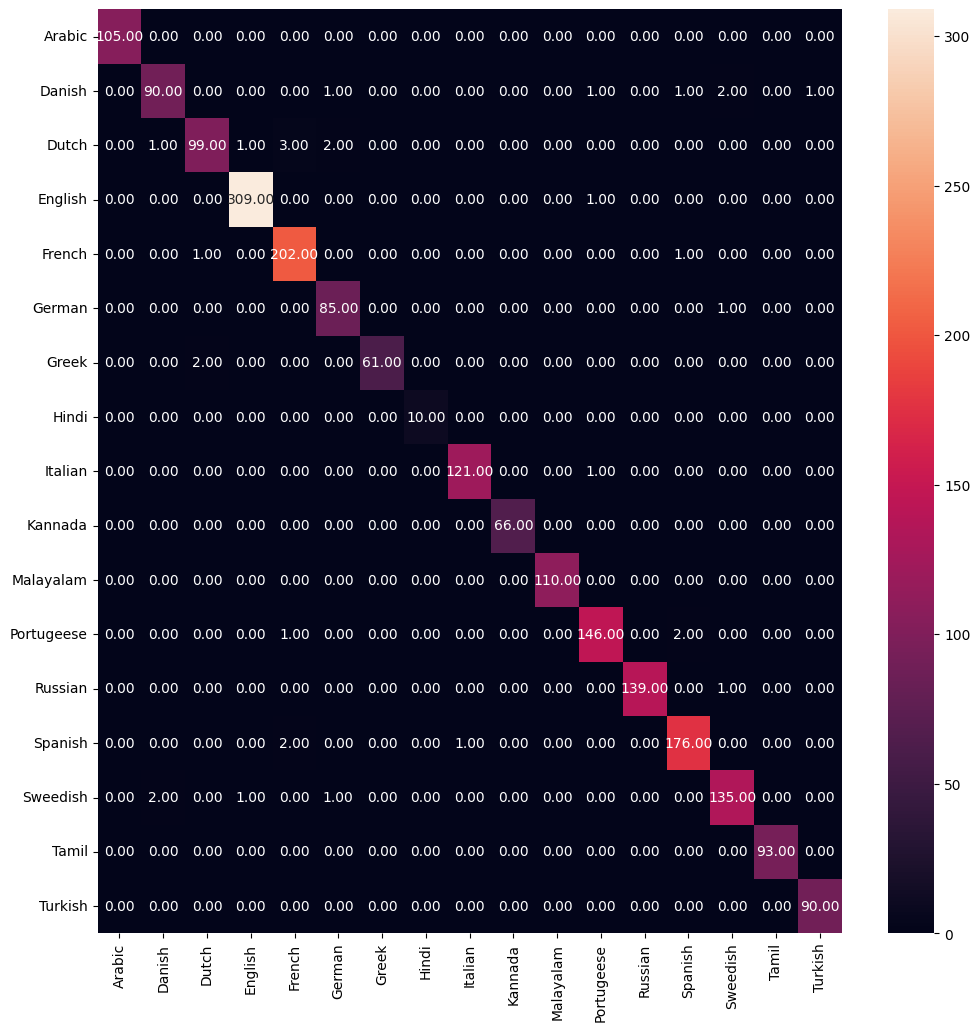

In [48]:
model = Sequential()

model.add(Input(shape=(16,)))
model.add(Reshape((16, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

model.save('model7.h5')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}\nprecision_score: {precision_score(y_test, y_pred, average="macro")}\nrecall_score: {recall_score(y_test, y_pred, average="macro")}\nf1_score: {f1_score(y_test, y_pred, average="macro")}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

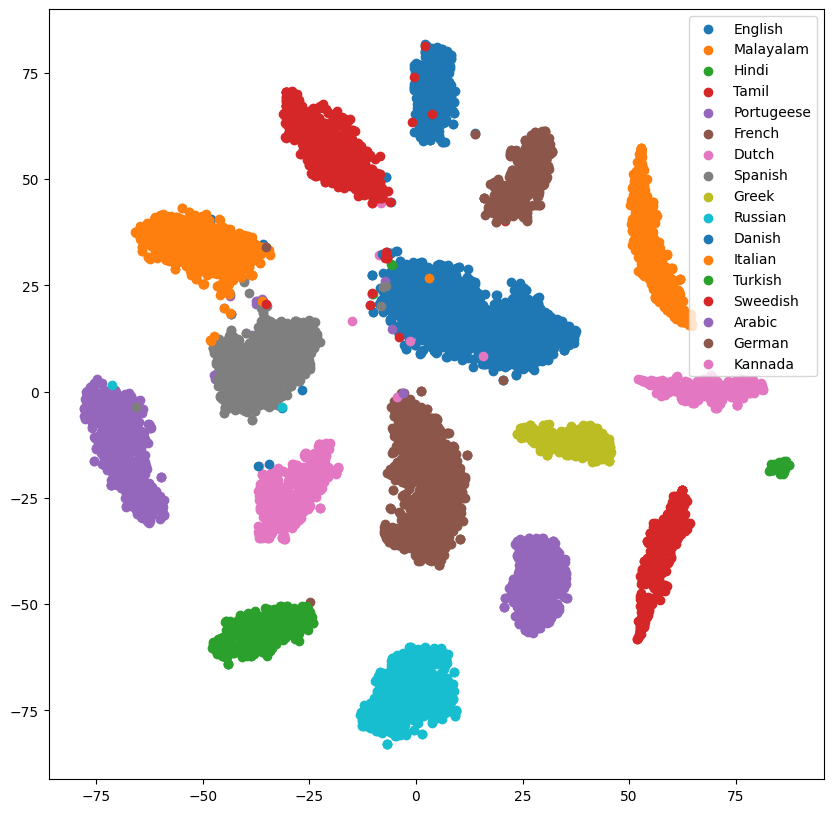

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

X = np.array(df1['Embedding'].tolist())
y = df1['Language'].values

X_embedded = TSNE(n_components=2).fit_transform(X)

plt.figure(figsize=(10, 10))

for i, lang in enumerate(df1['Language'].unique()):
    plt.scatter(X_embedded[y == lang, 0], X_embedded[y == lang, 1], label=lang)

plt.legend()
plt.show()

In [ ]:
from sklearn.utils import all_estimators

classifiers = []

for 